In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
import time
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import models
from gensim import corpora
from collections import defaultdict
from collections import Counter
import jieba.posseg as jp
import jieba.analyse
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# k1=0.5  #名词 'n' 
# k2=0.4  #动词 'v' 
# k3=0.3  #形容词/副词 'a' 'd' 
# k4=0.2  # 其他词性

k1=np.arange(0.5,1,0.1)  #名词 'n' 
k2=np.arange(0.4,1,0.1)  #动词 'v' 
k3=np.arange(0.3,1,0.1)  #形容词/副词 'a' 'd'
k4=np.arange(0.2,1,0.1)  # 其他词性

k_tuple=[]
for k_1 in k1:
    for k_2 in k2:
        for k_3 in k3:
            for k_4 in k4:
                if k_1>k_2 and k_2>k_3 and k_3>k_4:
                    k_tuple.append((k_1,k_2,k_3,k_4))

k_tuple=[(1,1,1,1)]

delta_k=0.1 #词性权重步长
flag_en2cn = {
    'a': '形容词', 'ad': '副形词', 'ag': '形语素', 'an': '名形词', 'b': '区别词',
    'c': '连词', 'd': '副词', 'df': '不要', 'dg': '副语素',
    'e': '叹词', 'f': '方位词', 'g': '语素', 'h': '前接成分',
    'i': '成语', 'j': '简称略语', 'k': '后接成分', 'l': '习用语',
    'm': '数词', 'mg': '数语素', 'mq': '数量词',
    'n': '名词', 'ng': '名语素', 'nr': '人名', 'nrfg': '古代人名', 'nrt': '音译人名',
    'ns': '地名', 'nt': '机构团体', 'nz': '其他专名',
    'o': '拟声词', 'p': '介词', 'q': '量词',
    'r': '代词', 'rg': '代语素', 'rr': '代词', 'rz': '代词',
    's': '处所词', 't': '时间词', 'tg': '时间语素',
    'u': '助词', 'ud': '得', 'ug': '过', 'uj': '的', 'ul': '了', 'uv': '地', 'uz': '着',
    'v': '动词', 'vd': '副动词', 'vg': '动语素', 'vi': '动词', 'vn': '名动词', 'vq': '动词',
    'x': '非语素字', 'y': '语气词', 'z': '状态词', 'zg': '状态语素',
}

n_list=['n', 'ng', 'nr', 'nrfg', 'nrt','ns', 'nt', 'nz']  #广义名词词性
v_list=['v', 'vd', 'vg', 'vi', 'vn', 'vq'] #广义动词词性
a_list=['a','ad','ag','an']  #广义形容词词性
d_list=['d','df','dg']  #广义副词词性


mark_punctuate=['，','。','？','……','”','“'] #去除语料标点
stop_words=[]  #停用词
with open('./中文停用词.txt','r',encoding='utf-8') as f:
    stop_words.append(f.readlines())
stop_words=stop_words[0]


"语料预处理"
def preprocess_str(te):
    text=te
    if ":" in text:
        text=text.split(":")[1]
    if '：' in text:
        text=text.split('：')[1]
    words=[w.word for w in jp.lcut(text) if w.word not in mark_punctuate and '\u4e00' <= w.word <= '\u9fff' and w.word not in stop_words] #Jieba中文分词处理
    word_class=[w.flag for w in jp.lcut(text) if w.word not in mark_punctuate and '\u4e00' <= w.word <= '\u9fff' and w.word not in stop_words] 
    
    return zip(words,word_class)

"统计词频"
def frequency_stats(zip_word):
    frequency=defaultdict(int)
    word_list=list(zip_word)
    for word in word_list:
        frequency[word]+=1
    return frequency

"词性权重"
def weight(word_class,delta_k=0):
    if word_class in n_list:
        return k1+delta_k
    elif word_class in v_list:
        return k2+delta_k
    elif word_class in a_list or word_class in d_list:
        return k3+delta_k
    else:
        return k4+delta_k

"词性权重"
def weight_(word_class,k_tuple):
    if word_class in n_list:
        return k_tuple[0]
    elif word_class in v_list:
        return k_tuple[1]
    elif word_class in a_list or word_class in d_list:
        return k_tuple[2]
    else:
        return k_tuple[3]
    
    
    
    

"词性加权TFIDF"
def get_weighted_word_tfidf(corpus_tfidf,delta_k):
    word_t_tfidf=[]  #统计第t个关键词tfidf
    for i in range(len(corpus_tfidf)):
        for m in range(len(corpus_tfidf[i])):
            id_tfidf=corpus_tfidf[i][m]
            word=id2word[id_tfidf[0]]
            word_class=corpus_pair[i][corpus[i].index(word)][1]
            corpus_tfidf[i][m]=(id_tfidf[0],id_tfidf[1]*weight(word_class,delta_k))     
            if id_tfidf[0]==word_tid:
                word_t_tfidf.append(id_tfidf[1]*weight(word_class,delta_k))  #找到第t个关键词对应的加权tfidf值
    word_t_tfidf=np.sum(word_t_tfidf)     #给定第t个词加权tfidf值
    return word_t_tfidf,corpus_tfidf

def get_weighted_word_tfidf_(corpus_tfidf,k_tuple):
    word_t_tfidf=[]  #统计第t个关键词tfidf
    for i in range(len(corpus_tfidf)):
        for m in range(len(corpus_tfidf[i])):
            id_tfidf=corpus_tfidf[i][m]
            word=id2word[id_tfidf[0]]
            word_class=corpus_pair[i][corpus[i].index(word)][1]
            corpus_tfidf[i][m]=(id_tfidf[0],id_tfidf[1]*weight_(word_class,k_tuple))     
            if id_tfidf[0]==word_tid:
                word_t_tfidf.append(id_tfidf[1]*weight_(word_class,k_tuple))  #找到第t个关键词对应的加权tfidf值
    word_t_tfidf=np.sum(word_t_tfidf)     #给定第t个词加权tfidf值
    return word_t_tfidf,corpus_tfidf

def plot_JS(lda,n_topics=25):
    "计算主题JS距离方差"
    divergence=[]
    for k in range(2,n_topics+1):
        var=d=0
        topics_terms=lda.state.get_lambda()
        topics_terms_proba = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)
        # 计算主题方差
        for t in range(k):
                for c in range(t, k):
                    proba_m=(topics_terms_proba[t]+topics_terms_proba[c])/2
                    js=0.5*scipy.stats.entropy(topics_terms_proba[t],proba_m)+ 0.5*scipy.stats.entropy(topics_terms_proba[c],proba_m) #计算JS距离
                    var += js
                    d += 1
        var_std = round(var / (k*d), 2)
        divergence.append(var_std)
    plt.figure(figsize=(15, 10))
    plt.plot(list(range(2, n_topics+1)), divergence, color='green')
    plt.scatter(list(range(2, n_topics+1)), divergence, color='red')
    plt.xticks(list(range(2, n_topics+1)))
    plt.xlabel('LDA主题数',fontproperties='SimHei')
    plt.ylabel('LDA主题JS距离方差',fontproperties='SimHei')   
    return divergence



"计算LDA模型主题一致性"
def coherence(lda,id2word, num_topics=25):
    topics_terms=lda.state.get_lambda()
    topics_terms_proba = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)
    coherence=[0] * len(topics_terms_proba)  
    dictionary=np.array(list(id2word.values()))
    for z, P_wzi in enumerate(topics_terms_proba):
        V_z = np.argsort(P_wzi)[:-(num_topics + 1):-1]
        W_z = dictionary[V_z]
        C_z = 0
        for m in range(1, num_topics):
            for l in range(m):
                D_vmvl = np.in1d(np.nonzero(X[:,V_z[l]]), np.nonzero(X[:,V_z[m]])).sum(dtype=int) + 1
                D_vl = np.count_nonzero(X[:,V_z[l]])
                if D_vl != 0:
                    C_z += math.log(D_vmvl / D_vl)

        coherence[z] = C_z
    return coherence



"--------------------------------------------LDA/TFIDF+LDA模型实验-------------------------------------"


"导入语料"
text=pd.read_excel("./参考语料库.xlsx")
corpus=[]  #分词
corpus_class=[] #词性标注
for line in text['评论内容'].tolist():
    if type(line)==str :
       zip_word=preprocess_str(line)
       frequency=frequency_stats(zip_word)
       corpus.append([key[0] for key in frequency if frequency[key] >=1 and len(key[0])>1])
       corpus_class.append([key[1] for key in frequency if frequency[key] >=1 and len(key[0])>1])

corpus=[word_list for word_list in corpus if len(word_list)>1]
corpus_class=[class_list for class_list in corpus_class if len(class_list)>1]
corpus_pair=[list(zip(corpus[i],corpus_class[i])) for i in range(len(corpus))]
"词袋模型"
dictionary=corpora.Dictionary(corpus)
word2id=dictionary.token2id #所有分词和对应索引
id2word={list(word2id.values())[i]:list(word2id.keys())[i] for i in range(len(list(word2id.keys())))} #键值互换
bow_corpus=[dictionary.doc2bow(text) for text in corpus]
"关键词词频和给定语义ωt计算"
corpus_df=pd.DataFrame({'cut_word':np.array(corpus)})
corpus_df['cut_word']=corpus_df['cut_word'].apply(lambda x:" ".join(x))
jieba.analyse.set_stop_words('./中文停用词.txt')
te=''
for i in range(len(corpus_df['cut_word'])):
    if len(corpus_df['cut_word'][i])>0:
     te+=corpus_df['cut_word'][i]+'\n'
c=Counter()
stat=0
for word in te.split():
    c[word]+=1
for word in c:
    if c[word]==1:
        stat+=1
t=int((math.sqrt(1+8*stat)-1)/2)
keyword_list=jieba.analyse.extract_tags(te,topK=1000,withWeight=True) #关键词词频
word_t=keyword_list[t-1]  #第t个关键词
word_tid=word2id[word_t[0]]  #第t个关键词索引

texts=corpus_df.cut_word.tolist() #导入文本生成词组列表
vec= TfidfVectorizer(stop_words=stop_words)
X= CountVectorizer(stop_words=stop_words).fit_transform(texts).toarray()

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

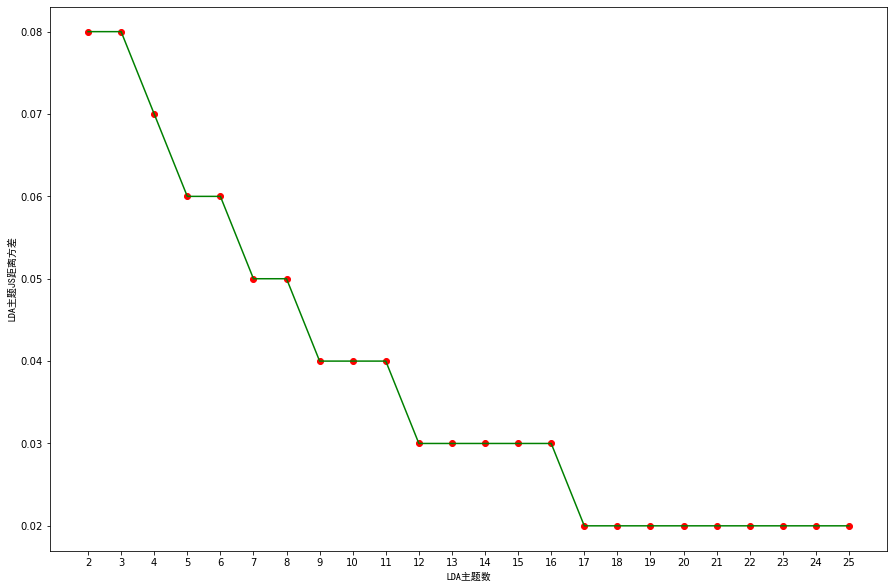

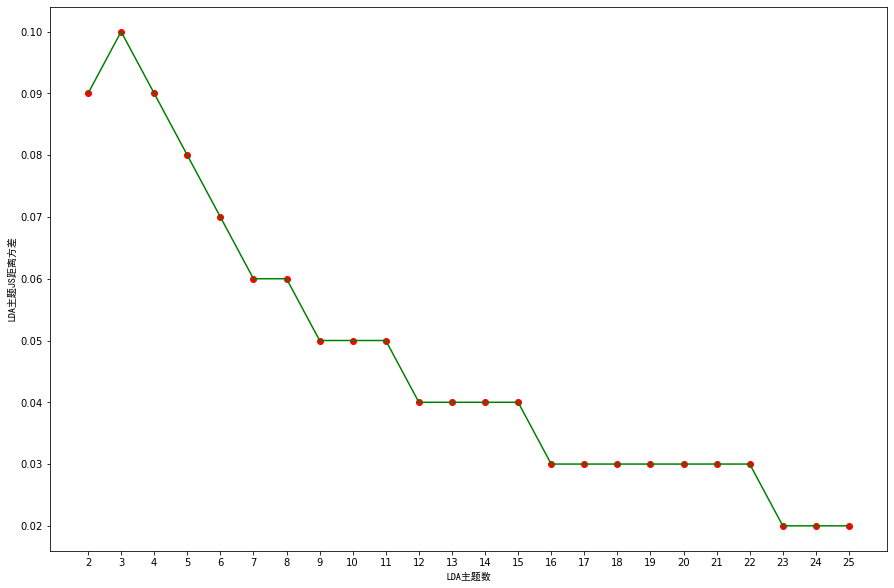

In [2]:

coh_lda=[]
coh_lda_tfidf=[]
js_lda=[]
js_lda_tfidf=[]
  
for k in k_tuple:
        "语料训练tf-idf模型TFDIF"
        tfidf=models.TfidfModel(bow_corpus)  
        corpus_tfidf=[tfidf[doc] for doc in bow_corpus]
        # delta_k=0.1*i  # 词性权重每次增加0.1  delta_k范围 0-0.4
        _,weighted_tfidf=get_weighted_word_tfidf_(corpus_tfidf,k)    #corpus_tfidf进行词性加权处理   
        "LDA建模"
        np.random.seed(1234)
        lda=LdaModel(corpus=bow_corpus,id2word=dictionary,num_topics=25,alpha=50,eta=0.01,passes=100,iterations=100)
        ldacm=CoherenceModel(model=lda,texts=corpus,dictionary=dictionary,coherence='c_uci')
        lda_tfidf=LdaModel(corpus=weighted_tfidf,id2word=dictionary,num_topics=25,alpha=50,eta=0.01,passes=100,iterations=100)
        ldacm_tfidf=CoherenceModel(model=lda_tfidf,texts=corpus,dictionary=dictionary,coherence='c_uci')
        "主题连贯性计算"
        coherence_lda=ldacm.get_coherence()
        coherence_lda_tfidf=ldacm_tfidf.get_coherence()
        coherence_lda_new=coherence(lda,id2word,num_topics=25)
        coherence_lda_tfidf_new=coherence(lda_tfidf,id2word, num_topics=25)
        doc_topic_lda = [a for a in lda[bow_corpus]]
        doc_topic_lda_tfidf = [a for a in lda_tfidf[bow_corpus]]
        topics_r_lda = lda.print_topics(num_topics = 25, num_words =20)
        topics_r_lda_tfidf = lda_tfidf.print_topics(num_topics = 25, num_words =20)
        "LDA模型可视化"
        data=pyLDAvis.gensim_models.prepare(lda,bow_corpus,dictionary)
        pyLDAvis.save_html(data,'online_lda.html')
        data=pyLDAvis.gensim_models.prepare(lda_tfidf,bow_corpus,dictionary)
        pyLDAvis.save_html(data,'online_lda_tfidf.html')
        "计算主题方差JS散度"
        divergence_lda=plot_JS(lda,25)
        divergence_lda_tfidf=plot_JS(lda_tfidf,25)
        coh_lda.append(coherence_lda_new)
        coh_lda_tfidf.append(coherence_lda_tfidf_new)
        js_lda.append( divergence_lda)
        js_lda_tfidf.append(divergence_lda_tfidf)


In [3]:
arr=np.array(coh_lda)
total = arr.sum()
avg = np.average(arr)
print(avg) 

-441.9014336742363


In [4]:
arr=np.array(coh_lda_tfidf)
total = arr.sum()
avg = np.average(arr)
print(avg) 


-432.4058488524489


In [5]:
arr=np.array(js_lda)
total = arr.sum()
avg = np.average(arr)
    #print(total)
print(avg) 

0.0375


In [6]:
arr=np.array(js_lda_tfidf)
total = arr.sum()
avg = np.average(arr)
    #print(total)
print(avg) 

0.04708333333333334


In [ ]:
def plot_JS(lda,n_topics=25):
    "计算主题JS距离方差"
    divergence=[]
    JS=[]
    for k in range(2,n_topics+1):
        var=d=0
        topics_terms=lda.state.get_lambda()
        topics_terms_proba = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)
        # 计算主题方差
        for t in range(k):
                for c in range(t, k):
                    proba_m=(topics_terms_proba[t]+topics_terms_proba[c])/2
                    js=0.5*scipy.stats.entropy(topics_terms_proba[t],proba_m)+ 0.5*scipy.stats.entropy(topics_terms_proba[c],proba_m) #计算JS距离
                    JS.append(js)
                    var += js
                    d += 1
        var_std = round(var / (k*d), 2)
        divergence.append(var_std)
    plt.figure(figsize=(15, 10))
    plt.plot(list(range(2, n_topics+1)), divergence, color='green')
    plt.scatter(list(range(2, n_topics+1)), divergence, color='red')
    plt.xticks(list(range(2, n_topics+1)))
    plt.xlabel('LDA主题数',fontproperties='SimHei')
    plt.ylabel('LDA主题JS距离方差',fontproperties='SimHei')   
    return divergence,JS

In [ ]:
coh_lda=[]
coh_lda_tfidf=[]
js_lda=[]
js_lda_tfidf=[]
  
for k in k_tuple:
        "语料训练tf-idf模型TFDIF"
        tfidf=models.TfidfModel(bow_corpus)  
        corpus_tfidf=[tfidf[doc] for doc in bow_corpus]
        # delta_k=0.1*i  # 词性权重每次增加0.1  delta_k范围 0-0.4
        _,weighted_tfidf=get_weighted_word_tfidf_(corpus_tfidf,k)    #corpus_tfidf进行词性加权处理   
        "LDA建模"
        np.random.seed(1234)
        lda=LdaModel(corpus=bow_corpus,id2word=dictionary,num_topics=25,alpha=50,eta=0.01,passes=100,iterations=100)
        ldacm=CoherenceModel(model=lda,texts=corpus,dictionary=dictionary,coherence='c_uci')
        lda_tfidf=LdaModel(corpus=weighted_tfidf,id2word=dictionary,num_topics=25,alpha=50,eta=0.01,passes=100,iterations=100)
        ldacm_tfidf=CoherenceModel(model=lda_tfidf,texts=corpus,dictionary=dictionary,coherence='c_uci')
        "主题连贯性计算"
        coherence_lda=ldacm.get_coherence()
        coherence_lda_tfidf=ldacm_tfidf.get_coherence()
        coherence_lda_new=coherence(lda,id2word,num_topics=25)
        coherence_lda_tfidf_new=coherence(lda_tfidf,id2word, num_topics=25)
        doc_topic_lda = [a for a in lda[bow_corpus]]
        doc_topic_lda_tfidf = [a for a in lda_tfidf[bow_corpus]]
        topics_r_lda = lda.print_topics(num_topics = 25, num_words =20)
        topics_r_lda_tfidf = lda_tfidf.print_topics(num_topics = 25, num_words =20)
        "LDA模型可视化"
        data=pyLDAvis.gensim_models.prepare(lda,bow_corpus,dictionary)
        pyLDAvis.save_html(data,'online_lda.html')
        data=pyLDAvis.gensim_models.prepare(lda_tfidf,bow_corpus,dictionary)
        pyLDAvis.save_html(data,'online_lda_tfidf.html')
        "计算主题方差JS散度"
        divergence_lda,JS=plot_JS(lda,25)
        divergence_lda_tfidf,JS_TFIDF=plot_JS(lda_tfidf,25)
        coh_lda.append(coherence_lda_new)
        coh_lda_tfidf.append(coherence_lda_tfidf_new)
        js_lda.append(JS)
        js_lda_tfidf.append(JS_TFIDF)
